In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [2]:
milk_prices = pd.read_csv("../../data/raw/milk-price/monthly-all-milk-price.csv", 
                          delimiter=',',
                          index_col = 0, parse_dates = [[0, 1]], 
                          infer_datetime_format = True,
                         ).to_period()
type(milk_prices['price'])

pandas.core.series.Series

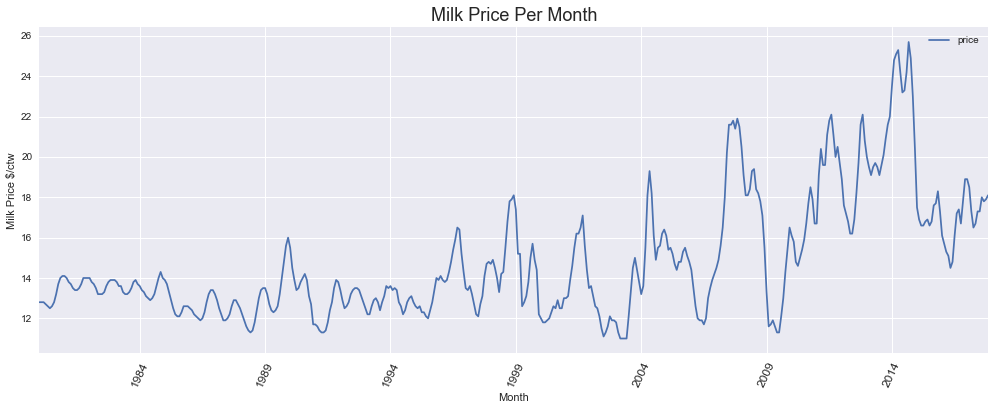

In [3]:
milk_prices.plot(figsize=(17,6))
_ = plt.xlabel('Month')
_ = plt.ylabel('Milk Price $/ctw')
_ = plt.xticks(rotation='65', size=12)
_ = plt.title('Milk Price Per Month',size=18)
plt.show()

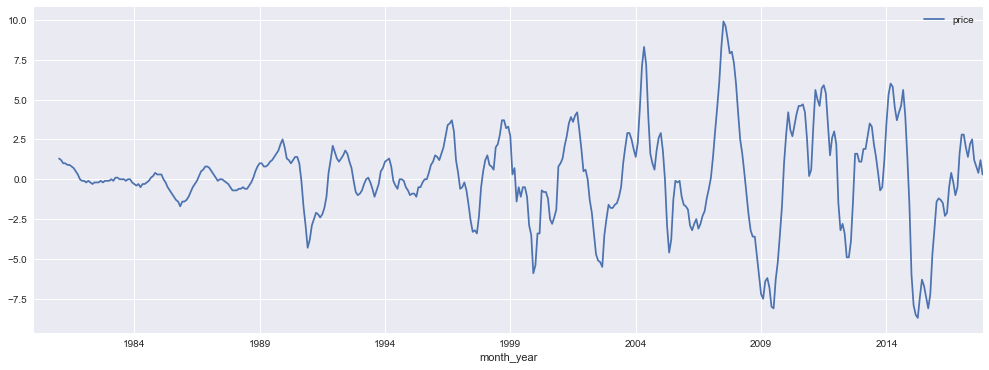

In [4]:
# Plot the difference between the price over last year
milk_prices.diff(12).plot(figsize=(17,6))

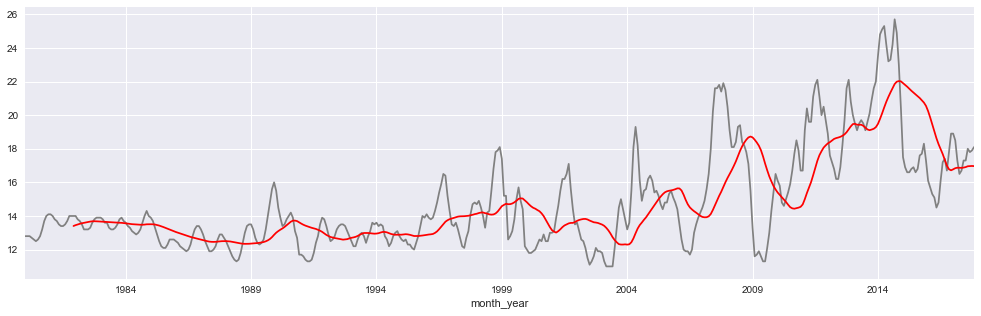

In [5]:
r = milk_prices.rolling(window = 24)

milk_prices['price'].plot(color = 'gray', figsize=(17,5))
r.mean()['price'].plot(color = 'red', figsize=(17,5))

/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


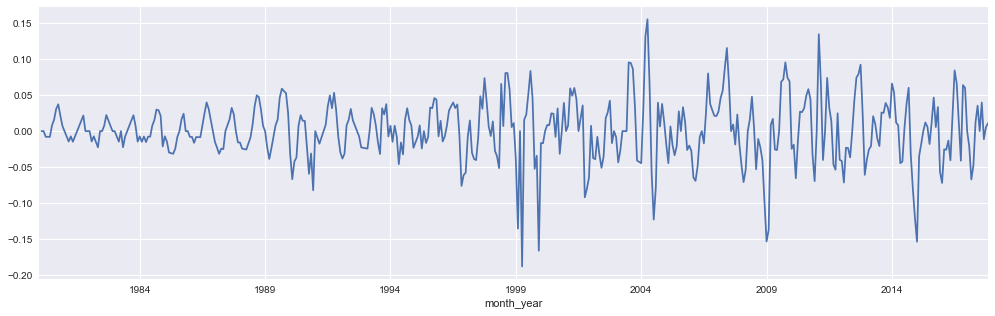

In [6]:
from statsmodels.tsa import stattools

milk_log = np.log(milk_prices)
milk_diff = milk_log.price - milk_log.price.shift()
milk_diff.plot(figsize=(17,5))
milk_diff.dropna(inplace = True)

In [7]:
type(milk_diff)

pandas.core.series.Series

In [8]:
from statsmodels.tsa.stattools import adfuller
X = milk_diff.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.870223
p-value: 0.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [9]:
## At this p level we can reject the null hypothesis and identify that milk_diff series is stationary
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, **kwargs)
    Plot lines and/or markers to the
    :class:`~matplotlib.axes.Axes`.  *args* is a variable length
    argument, allowing for multiple *x*, *y* pairs with an
    optional format string.  For example, each of the following is
    legal::
    
        plot(x, y)        # plot x and y using default line style and color
        plot(x, y, 'bo')  # plot x and y using blue circle markers
        plot(y)           # plot y using x as index array 0..N-1
        plot(y, 'r+')     # ditto, but with red plusses
    
    If *x* and/or *y* is 2-dimensional, then the corresponding columns
    will be plotted.
    
    If used with labeled data, make sure that the color spec is not
    included as an element in data, as otherwise the last case
    ``plot("v","r", data={"v":..., "r":...)``
    can be interpreted as the first case which would do ``plot(v, r)``
    using the default line style and color.
    
    If not used wi

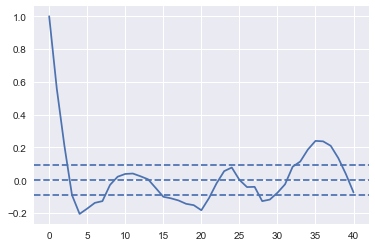

In [10]:
acf_result = stattools.acf(milk_diff)
plt.plot(acf_result)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(milk_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(milk_diff)),linestyle='--')

In [11]:
# We don't pull these out of thin air, but rather draw them from the data
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(milk_diff.values, nlags = 20)
lag_pacf = pacf(milk_diff.values, nlags = 20)

/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


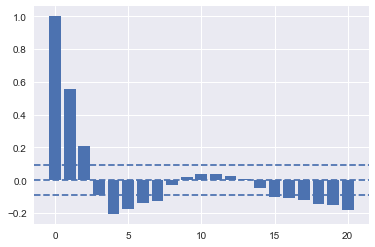

In [12]:
plt.bar(left = range(len(lag_acf)), height = lag_acf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(milk_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(milk_diff)),linestyle='--')

/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


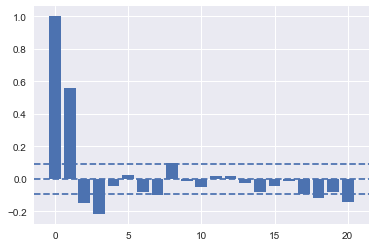

In [13]:
plt.bar(left = range(len(lag_pacf)), height = lag_pacf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(milk_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(milk_diff)),linestyle='--')

In [14]:
from statsmodels.tsa.arima_model import ARIMA

/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 1.5743')

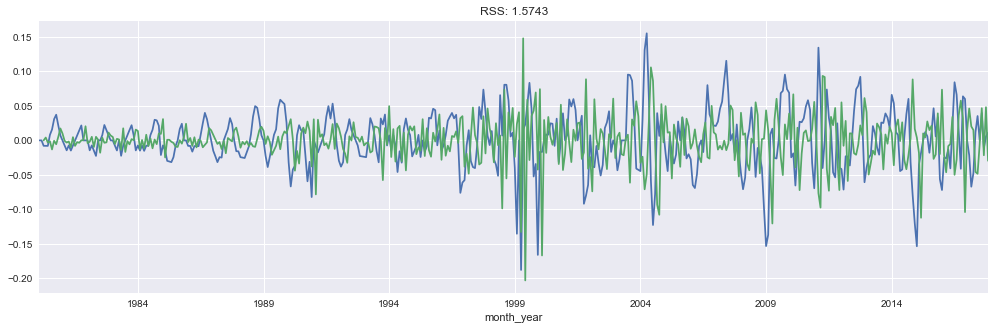

In [15]:
milk_diff = milk_diff.dropna()
model = ARIMA(milk_diff, order=(3, 2, 0))  
results_AR = model.fit(disp=-1)  
milk_diff.plot(figsize=(17,5))
results_AR.fittedvalues.plot(figsize=(17,5))
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues.values - milk_diff.values[2:])**2))

/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 0.8945')

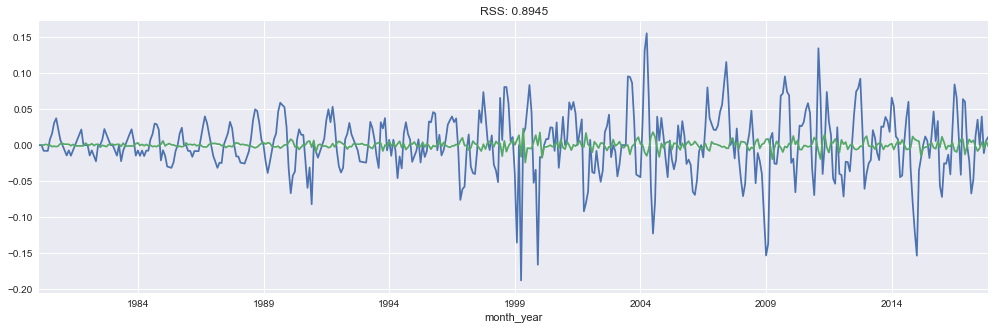

In [16]:
model = ARIMA(milk_diff, order=(0, 1, 1))  
results_AR = model.fit(disp=-1)  
milk_diff.plot(figsize=(17,5))
results_AR.fittedvalues.plot(figsize=(17,5))
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues.values - milk_diff.values[1:])**2))